# Introducción a LightGBM

Este notebook cubre:
- ¿Qué es LightGBM?
- Ventajas y características
- Instalación y configuración
- Uso básico de LightGBM
- Parámetros principales
- Comparación con otros algoritmos

## 1. ¿Qué es LightGBM?

**LightGBM** (Light Gradient Boosting Machine) es un framework de gradient boosting desarrollado por Microsoft.

### Características principales:
- **Rápido**: Optimizado para velocidad y eficiencia de memoria
- **Escalable**: Maneja grandes volúmenes de datos
- **Preciso**: Alto rendimiento en tareas de machine learning
- **Soporte nativo**: Maneja valores categóricos sin necesidad de one-hot encoding
- **Múltiples tareas**: Clasificación, regresión, ranking

### Ventajas sobre otros algoritmos:
1. **Velocidad**: Más rápido que XGBoost y otros algoritmos de boosting
2. **Memoria**: Uso eficiente de memoria
3. **Precisión**: Mejor rendimiento en muchos casos
4. **Paralelización**: Soporte para GPU y procesamiento paralelo
5. **Manejo de datos grandes**: Optimizado para datasets grandes

## 2. Instalación

In [12]:
# Instalar LightGBM y mysql-connector (descomenta si no están instalados)
# !pip install lightgbm mysql-connector-python

import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import Error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')

print(f"LightGBM versión: {lgb.__version__}")
print("Librerías importadas correctamente")

LightGBM versión: 4.6.0
Librerías importadas correctamente


## 3. Conceptos Fundamentales de LightGBM

### 3.1 Gradient Boosting

LightGBM utiliza **Gradient Boosting**, que es una técnica de ensemble learning:

1. **Boosting**: Combina múltiples modelos débiles (árboles) en un modelo fuerte
2. **Gradient**: Utiliza el gradiente de la función de pérdida para entrenar cada árbol
3. **Secuencial**: Cada árbol se entrena para corregir los errores del anterior

### 3.2 Diferencias Clave: Leaf-wise vs Level-wise

- **XGBoost/otros**: Usan level-wise (crecen nivel por nivel)
- **LightGBM**: Usa leaf-wise (crece hoja por hoja, eligiendo la hoja con mayor ganancia)

**Ventaja**: Leaf-wise puede lograr menor pérdida con el mismo número de hojas, pero requiere más cuidado con el overfitting.

## 4. Ejemplo Básico con Datos Simulados

In [13]:
# Configuración de la base de datos (misma que 02_modelos_clasificacion.ipynb)
DB_CONFIG = {
    'host': '127.0.0.1',
    'database': 'palantir_maintenance',
    'user': 'root',
    'password': 'admin',
    'port': 3306
}

def cargar_datos():
    """Cargar datos de la tabla faliure_probability_base"""
    try:
        connection = mysql.connector.connect(**DB_CONFIG)
        if connection.is_connected():
            query = """
            SELECT * 
            FROM faliure_probability_base
            ORDER BY asset_id, reading_date
            """
            df = pd.read_sql(query, connection)
            connection.close()
            return df
    except Error as e:
        print(f"Error al conectar: {e}")
        return None

# Cargar datos
df = cargar_datos()
if df is not None:
    print(f"Datos cargados: {df.shape}")
    print(f"\nColumnas: {list(df.columns)}")
    print(f"\nPrimeras filas:")
    display(df.head())
else:
    print("No se pudieron cargar los datos. Verifica la conexión a la base de datos.")

Datos cargados: (1200, 44)

Columnas: ['base_id', 'asset_id', 'reading_date', 'faliure', 'extraction_date', 'asset_age_days', 'asset_status', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value', 'sensor_avg_warning_value', 'sensor_avg_critical_value', 'sensor_max_value', 'sensor_min_value', 'sensor_std_value', 'failure_count_365d', 'failure_critical_count', 'failure_high_count', 'failure_medium_count', 'failure_low_count', 'failure_avg_downtime', 'failure_total_downtime', 'failure_unresolved_count', 'days_since_last_failure', 'task_total_365d', 'task_completed_count', 'task_in_progress_count', 'task_pending_count', 'task_avg_estimated_hours', 'task_avg_actual_hours', 'task_total_hours', 'days_since_last_task', 'order_total_365d', 'order_preventive_count', 'order_corrective_count', 'order_emergency_count', 'order_completed_count', 'order_avg_estimated_cost', 'order_avg_actual_cost', 'order_total_actual_cost', 'days_since_last_o

,base_id,asset_id,reading_date,faliure,extraction_date,asset_age_days,asset_status,sensor_total_readings_30d,sensor_warning_count_30d,sensor_critical_count_30d,...,order_preventive_count,order_corrective_count,order_emergency_count,order_completed_count,order_avg_estimated_cost,order_avg_actual_cost,order_total_actual_cost,days_since_last_order,created_at,updated_at
0,2,1,2022-10-01,1,2026-02-08 18:35:00,990,operational,120,15,0,...,69,37,3,37,4580.13,4811.36,178020.43,6,2026-02-08 18:35:00,2026-02-08 18:35:00
1,10,1,2022-10-02,1,2026-02-08 18:35:00,991,operational,240,24,0,...,69,37,3,37,4580.13,4811.36,178020.43,7,2026-02-08 18:35:00,2026-02-08 18:35:00
2,18,1,2022-10-03,0,2026-02-08 18:35:00,992,operational,360,41,0,...,69,37,3,37,4580.13,4811.36,178020.43,8,2026-02-08 18:35:00,2026-02-08 18:35:00
3,26,1,2022-10-04,0,2026-02-08 18:35:00,993,operational,480,51,0,...,69,37,3,37,4580.13,4811.36,178020.43,9,2026-02-08 18:35:00,2026-02-08 18:35:00
4,34,1,2022-10-05,0,2026-02-08 18:35:00,994,operational,600,64,0,...,69,37,3,37,4580.13,4811.36,178020.43,10,2026-02-08 18:35:00,2026-02-08 18:35:00


In [14]:
# Preparar características y variable objetivo
if df is not None and 'faliure' in df.columns:
    # Columnas a excluir (identificadores, fechas, variable objetivo)
    exclude_cols = ['base_id', 'asset_id', 'reading_date', 'faliure', 
                    'extraction_date', 'asset_status', 'created_at', 'updated_at']
    
    # Seleccionar características numéricas
    feature_columns = [col for col in df.columns if col not in exclude_cols]
    
    # Preparar datos
    X = df[feature_columns].select_dtypes(include=[np.number]).fillna(0)
    y = df['faliure'].astype(int)
    
    print(f"Características seleccionadas: {len(X.columns)}")
    print(f"\nColumnas: {list(X.columns)}")
    print(f"\nForma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"\nDistribución de clases (faliure):")
    print(y.value_counts())
    print(f"\nTasa de fallas: {y.mean()*100:.2f}%")
else:
    print("No hay datos o columna 'faliure' no encontrada")

Características seleccionadas: 36

Columnas: ['asset_age_days', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value', 'sensor_avg_warning_value', 'sensor_avg_critical_value', 'sensor_max_value', 'sensor_min_value', 'sensor_std_value', 'failure_count_365d', 'failure_critical_count', 'failure_high_count', 'failure_medium_count', 'failure_low_count', 'failure_avg_downtime', 'failure_total_downtime', 'failure_unresolved_count', 'days_since_last_failure', 'task_total_365d', 'task_completed_count', 'task_in_progress_count', 'task_pending_count', 'task_avg_estimated_hours', 'task_avg_actual_hours', 'task_total_hours', 'days_since_last_task', 'order_total_365d', 'order_preventive_count', 'order_corrective_count', 'order_emergency_count', 'order_completed_count', 'order_avg_estimated_cost', 'order_avg_actual_cost', 'order_total_actual_cost', 'days_since_last_order']

Forma de X: (1200, 36)
Forma de y: (1200,)

Distribución de clases (fa

## 5. Entrenamiento Básico de LightGBM

In [15]:
# Dividir datos (con estratificación para mantener proporción de clases)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalar características
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print(f"Datos de entrenamiento: {X_train_scaled.shape}")
print(f"Datos de prueba: {X_test_scaled.shape}")
print(f"\nDistribución en entrenamiento:")
print(y_train.value_counts())
print(f"\nDistribución en prueba:")
print(y_test.value_counts())

Datos de entrenamiento: (960, 36)
Datos de prueba: (240, 36)

Distribución en entrenamiento:
faliure
0    880
1     80
Name: count, dtype: int64

Distribución en prueba:
faliure
0    220
1     20
Name: count, dtype: int64


In [16]:
# Crear Dataset de LightGBM
# LightGBM requiere un formato especial de Dataset
train_data = lgb.Dataset(X_train_scaled, label=y_train)
test_data = lgb.Dataset(X_test_scaled, label=y_test, reference=train_data)

print("Datasets de LightGBM creados correctamente")
print(f"Features: {list(X_train_scaled.columns)[:5]}... (total: {len(X_train_scaled.columns)})")

Datasets de LightGBM creados correctamente
Features: ['asset_age_days', 'sensor_total_readings_30d', 'sensor_warning_count_30d', 'sensor_critical_count_30d', 'sensor_avg_normal_value']... (total: 36)


In [17]:
# Parámetros básicos de LightGBM para clasificación binaria (faliure: 0/1)
# Calculamos scale_pos_weight para manejar el desbalance de clases
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1

params = {
    'objective': 'binary',  # Para clasificación binaria (faliure: 0/1)
    'metric': 'binary_logloss',  # Métrica de evaluación para binario
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Número de hojas (importante para controlar complejidad)
    'learning_rate': 0.05,  # Tasa de aprendizaje
    'feature_fraction': 0.9,  # Fracción de características a usar en cada árbol
    'bagging_fraction': 0.8,  # Fracción de datos a usar en cada árbol
    'bagging_freq': 5,  # Frecuencia de bagging
    'scale_pos_weight': scale_pos_weight,  # Manejar desbalance de clases
    'verbose': 0  # Silenciar output
}

print("Parámetros configurados para predicción de fallas (binario):")
for key, value in params.items():
    print(f"  {key}: {value}")

Parámetros configurados para predicción de fallas (binario):
  objective: binary
  metric: binary_logloss
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.9
  bagging_fraction: 0.8
  bagging_freq: 5
  scale_pos_weight: 11.0
  verbose: 0


In [18]:
# Entrenar el modelo
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,  # Número de iteraciones (árboles)
    valid_sets=[train_data, test_data],
    valid_names=['train', 'eval'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10),  # Parar si no mejora en 10 rondas
        lgb.log_evaluation(period=10)  # Mostrar métricas cada 10 rondas
    ]
)

print("\nModelo entrenado correctamente")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's binary_logloss: 0.13795	eval's binary_logloss: 0.142563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

## 6. Predicciones y Evaluación

In [19]:
# Hacer predicciones (clasificación binaria)
y_pred_proba = model.predict(X_test_scaled, num_iteration=model.best_iteration)
y_pred_class = (y_pred_proba > 0.5).astype(int)  # Umbral de 0.5 para clasificación binaria

# Evaluar
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=['Sin Falla (0)', 'Con Falla (1)']))

Accuracy: 0.9875

Classification Report:
               precision    recall  f1-score   support

Sin Falla (0)       1.00      0.99      0.99       220
Con Falla (1)       0.90      0.95      0.93        20

     accuracy                           0.99       240
    macro avg       0.95      0.97      0.96       240
 weighted avg       0.99      0.99      0.99       240



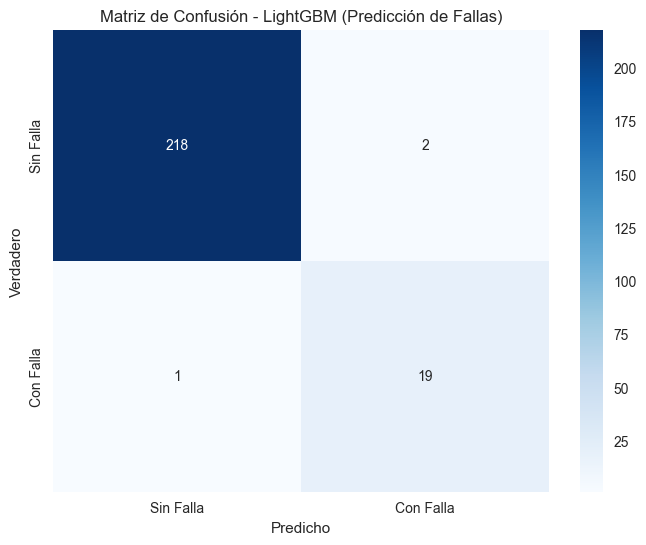

In [20]:
# Matriz de confusión para predicción de fallas
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Falla', 'Con Falla'],
            yticklabels=['Sin Falla', 'Con Falla'])
plt.title('Matriz de Confusión - LightGBM (Predicción de Fallas)')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

## 7. Parámetros Principales de LightGBM

### 7.1 Parámetros de Control

| Parámetro | Descripción | Valores Típicos |
|-----------|-------------|-----------------|
| `objective` | Función objetivo | 'multiclass', 'binary', 'regression' |
| `metric` | Métrica de evaluación | 'multi_logloss', 'binary_logloss', 'rmse' |
| `boosting_type` | Tipo de boosting | 'gbdt', 'dart', 'goss', 'rf' |
| `num_leaves` | Número de hojas | 31 (default), típicamente 2^max_depth - 1 |
| `learning_rate` | Tasa de aprendizaje | 0.01 - 0.3 |
| `num_iterations` | Número de árboles | 100 - 10000 |

### 7.2 Parámetros de Regularización

| Parámetro | Descripción | Efecto |
|-----------|-------------|--------|
| `lambda_l1` | Regularización L1 | Reduce overfitting, hace el modelo más simple |
| `lambda_l2` | Regularización L2 | Reduce overfitting |
| `min_gain_to_split` | Ganancia mínima para dividir | Previene divisiones inútiles |
| `min_data_in_leaf` | Mínimo de datos en hoja | Previene overfitting |

### 7.3 Parámetros de Sampling

| Parámetro | Descripción |
|-----------|-------------|
| `feature_fraction` | Fracción de características a usar (0-1) |
| `bagging_fraction` | Fracción de datos a usar (0-1) |
| `bagging_freq` | Frecuencia de bagging (cada N iteraciones) |

## 8. Importancia de Características

Top 10 características más importantes para predecir fallas:
                      feature   importance
18    days_since_last_failure  7608.812999
10         failure_count_365d  2953.120438
1   sensor_total_readings_30d  2918.070577
35      days_since_last_order   620.589346
32   order_avg_estimated_cost   529.111066
26       days_since_last_task   339.752381
11     failure_critical_count   328.181449
16     failure_total_downtime   272.390780
23   task_avg_estimated_hours   133.061005
4     sensor_avg_normal_value   126.116311


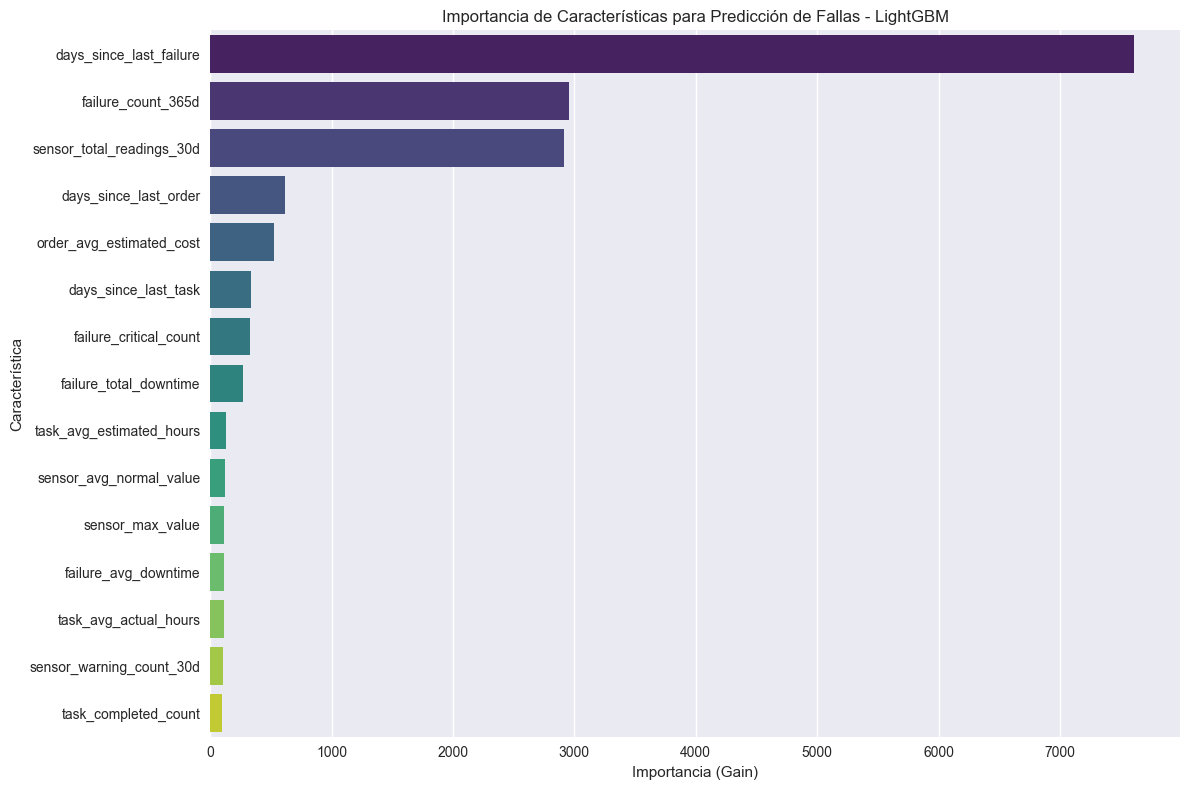

In [21]:
# Obtener importancia de características (usando nombres reales de la tabla faliure_probability_base)
feature_importance = pd.DataFrame({
    'feature': list(X_train_scaled.columns),
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 10 características más importantes para predecir fallas:")
print(feature_importance.head(10))

# Visualizar
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title('Importancia de Características para Predicción de Fallas - LightGBM')
plt.xlabel('Importancia (Gain)')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

## 9. Visualización del Modelo

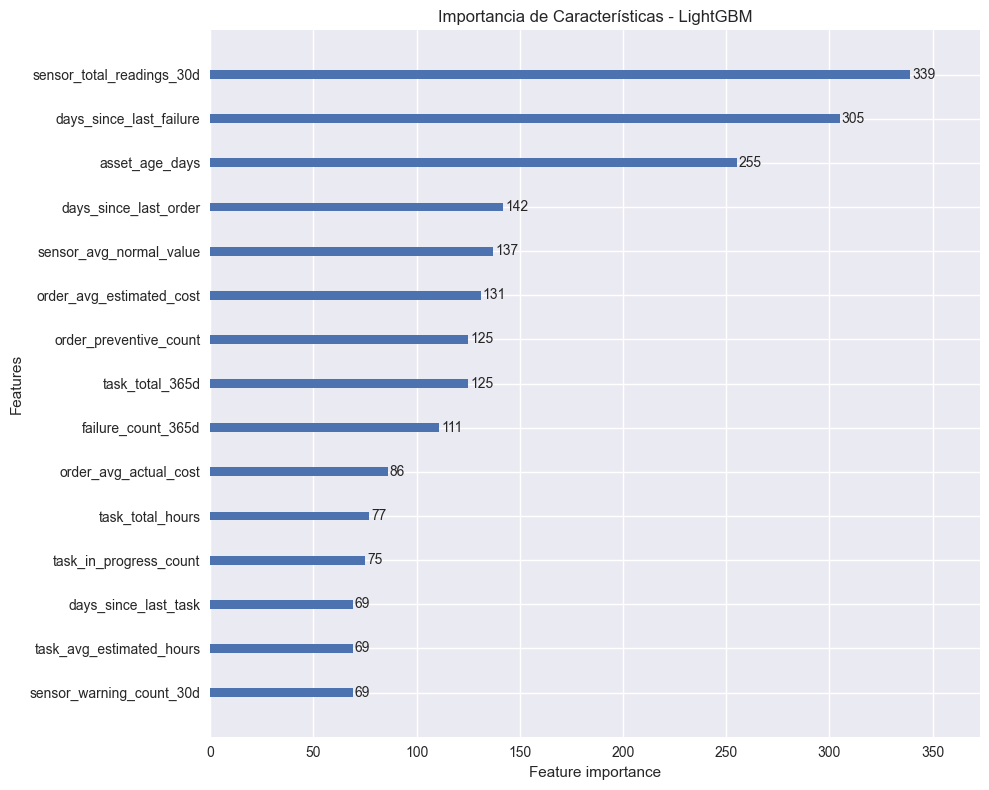

In [22]:
# Gráfico de importancia de características (método alternativo)
lgb.plot_importance(model, max_num_features=15, figsize=(10, 8))
plt.title('Importancia de Características - LightGBM')
plt.tight_layout()
plt.show()

## 10. Comparación con Scikit-learn API

LightGBM también tiene una API compatible con scikit-learn, más fácil de usar:

In [23]:
# Usando la API de scikit-learn (más simple)
from lightgbm import LGBMClassifier

# Crear modelo para clasificación binaria (predicción de fallas)
lgbm_classifier = LGBMClassifier(
    objective='binary',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,  # Manejar desbalance de clases
    random_state=42,
    verbose=-1
)

# Entrenar
lgbm_classifier.fit(X_train_scaled, y_train)

# Predecir
y_pred_sklearn = lgbm_classifier.predict(X_test_scaled)

# Evaluar
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Accuracy (scikit-learn API): {accuracy_sklearn:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_sklearn, target_names=['Sin Falla', 'Con Falla']))

print("\nVentajas de la API de scikit-learn:")
print("- Más familiar para usuarios de scikit-learn")
print("- Compatible con pipelines y GridSearchCV")
print("- Más simple de usar")

Accuracy (scikit-learn API): 0.9917

Classification Report:
              precision    recall  f1-score   support

   Sin Falla       1.00      1.00      1.00       220
   Con Falla       0.95      0.95      0.95        20

    accuracy                           0.99       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.99      0.99      0.99       240


Ventajas de la API de scikit-learn:
- Más familiar para usuarios de scikit-learn
- Compatible con pipelines y GridSearchCV
- Más simple de usar


## 11. Tuning de Hiperparámetros Básico

In [24]:
# Ejemplo de búsqueda de hiperparámetros básica para predicción de fallas
from sklearn.model_selection import GridSearchCV

# Definir grid de parámetros
param_grid = {
    'num_leaves': [15, 31, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200]
}

# Crear modelo base para clasificación binaria
lgbm_base = LGBMClassifier(
    objective='binary',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=-1
)

# Grid Search (comentado porque puede tardar)
# grid_search = GridSearchCV(
#     lgbm_base,
#     param_grid,
#     cv=3,
#     scoring='f1',  # F1 score es mejor para clases desbalanceadas
#     n_jobs=-1,
#     verbose=1
# )
# 
# grid_search.fit(X_train_scaled, y_train)
# print(f"Mejores parámetros: {grid_search.best_params_}")
# print(f"Mejor score: {grid_search.best_score_:.4f}")

print("Grid Search definido (descomenta para ejecutar)")
print("Nota: Para datos desbalanceados, usamos 'f1' como métrica de scoring")

Grid Search definido (descomenta para ejecutar)
Nota: Para datos desbalanceados, usamos 'f1' como métrica de scoring


## 12. Ventajas y Cuándo Usar LightGBM

### Ventajas:
1. ✅ **Velocidad**: Muy rápido, especialmente en datasets grandes
2. ✅ **Memoria**: Uso eficiente de memoria
3. ✅ **Precisión**: Alto rendimiento en muchos problemas
4. ✅ **Manejo de categóricas**: Soporte nativo sin one-hot encoding
5. ✅ **GPU**: Soporte para aceleración por GPU

### Cuándo usar LightGBM:
- ✅ Datasets grandes (>10,000 filas)
- ✅ Muchas características
- ✅ Necesitas velocidad
- ✅ Problemas de clasificación o regresión
- ✅ Datos con características categóricas

### Cuándo NO usar LightGBM:
- ❌ Datasets muy pequeños (<1,000 filas) - puede overfittear fácilmente
- ❌ Necesitas interpretabilidad detallada (usa árboles simples)
- ❌ Datos con muchas características irrelevantes (usa feature selection primero)

## Resumen

En este notebook hemos aprendido:
1. ✅ ¿Qué es LightGBM y sus ventajas
2. ✅ Carga de datos desde la tabla `faliure_probability_base` usando `cargar_datos()`
3. ✅ Entrenamiento con datos reales de mantenimiento predictivo
4. ✅ Parámetros principales para clasificación binaria
5. ✅ Manejo de clases desbalanceadas con `scale_pos_weight`
6. ✅ Importancia de características para predicción de fallas
7. ✅ API de scikit-learn vs API nativa
8. ✅ Cuándo usar LightGBM

**Datos utilizados:** Tabla `faliure_probability_base` con la variable objetivo `faliure` (falla en próximos 7 días).

**Próximos pasos:** En el siguiente notebook (05_lightgbm_prediccion_fallas.ipynb) profundizaremos en el análisis y guardaremos modelos para producción.